本文主要以kaggle一次二分类竞赛数据为例，深入研究改进forest

LayerDTree是LayerForest的精简版，是对Forest进一步探索的基础

- 数据地址：https://www.kaggle.com/c/porto-seguro-safe-driver-prediction
- 数据特点：
  - 非常不均衡、缺失值严重、二分类
- 包含内容：
  1. 数据获取
  2. 模型应用
  3. 结果分析

# Stage-1：获取数据

In [1]:
import os
import numpy as np
import pandas as pd
import time
import os.path as osp

In [6]:
import DataHelper
import importlib
importlib.reload(DataHelper)

<module 'DataHelper' from 'C:\\github_workspace\\ecoForest\\DataHelper.py'>

In [258]:
X_train,y_train, X_sub, y_sub = DataHelper.get_driver_data()

X.shape: (32561, 14) y.shape: (32561,)
X.shape: (16281, 14) y.shape: (16281,)


In [7]:
X_train,y_train, X_sub, y_sub = DataHelper.get_letter_data()

X.shape: (16000, 16) y.shape: (16000,)
X.shape: (4000, 16) y.shape: (4000,)


In [8]:
y_sub[:50]

array([20, 13, 21,  8, 13,  7,  4, 24,  6,  4, 13,  1,  6, 11,  4,  6, 12,
        3, 24, 17, 15,  3,  4, 22,  3, 16, 17,  6, 24, 17,  3,  9,  2,  8,
       19,  2, 13, 12,  1,  7, 17, 16,  0,  6, 16,  7, 10,  6,  0,  0])

In [4]:
y_sub[:50]

array([20, 13, 21,  8, 13,  7,  4, 24,  6,  4, 13,  1,  6, 11,  4,  6, 12,
        3, 24, 17, 15,  3,  4, 22,  3, 16, 17,  6, 24, 17,  3,  9,  2,  8,
       19,  2, 13, 12,  1,  7, 17, 16,  0,  6, 16,  7, 10,  6,  0,  0])

# Stage-2：模型应用

In [9]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import ForestUtils
import time
import random
from sklearn import metrics

In [10]:
import EnhancedDTree
import EnhancedForest
import importlib

In [11]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [12]:
def acc_prob(y_sub, p_train):
    threshold = [x*0.01 for x in range(30,71,1)]
    result = []
    for i in range(len(threshold)):
        test_y_acc_index = np.where(p_train > threshold[i])[0]
        test_y_acc = np.array([0] * len(p_train))
        test_y_acc[test_y_acc_index] = 1
        tmp = metrics.accuracy_score(y_sub, test_y_acc)
        result.append(tmp)
    result = np.array(result)
    return np.max(result)

# 决策树算法

In [13]:
clf = DecisionTreeClassifier()
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [10]:
clf = clf.fit(X_train, y_train)

In [11]:
# p_train = clf.predict_proba(X_sub)
# p_train = [item[1] for item in p_train]
# p_train = np.array(p_train)
# print("data auc", metrics.roc_auc_score(y_sub, p_train))
# print("data log", metrics.log_loss(y_sub, p_train)) 
# print("data acc", acc_prob(y_sub, p_train))

In [12]:
p_train = clf.predict(X_sub)
print("data auc", metrics.accuracy_score(y_sub, p_train))

data auc 0.8785


# 随机森林算法

In [13]:
# rf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=4, random_state=1024, verbose=True, min_samples_leaf=10)
# rf

In [14]:
rf = RandomForestClassifier(n_estimators=200)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
# p_train = rf.predict_proba(X_sub)
# p_train = [item[1] for item in p_train]
# p_train = np.array(p_train)
# print("data auc", metrics.roc_auc_score(y_sub, p_train))
# print("data log", metrics.log_loss(y_sub, p_train))
# print("data acc", acc_prob(y_sub, p_train))

In [17]:
p_train = rf.predict(X_sub)
print("data acc", metrics.accuracy_score(y_sub, p_train))
# print("data log", metrics.log_loss(y_sub, p_train)) 

data acc 0.96575


In [18]:
p_train = rf.predict(X_train)
print("data acc", metrics.accuracy_score(y_train, p_train))
# print("data log", metrics.log_loss(y_sub, p_train)) 

data acc 1.0


# XGB算法

In [23]:
import xgboost as xgb

c:\program files\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
params = {
#     'objective': 'binary:logistic',
    'objective':'multi:softmax',
#     'objective':'multi:softprob',
    'num_class':26
#     'silent': True,
    
#     'max_depth': 4,
#     'eta': 0.020,
#     'gamma': 0.65,
    
#     'colsample_bytree': 0.8,
#     'subsample': 0.6,
    
#     'num_boost_round' : 700,
#     'min_child_weight': 10.0,
#     'max_delta_step': 1.8,
}

In [25]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n

def gini_normalized(a, p):
#     if p.ndim == 2:#Required for sklearn wrapper
#         p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

# Create an XGBoost-compatible metric from Gini
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

def acc_xgb(preds, dtrain):
    labels = dtrain.get_label()
    acc_score = metrics.accuracy_score(labels, preds)
    return 'acc', acc_score

In [26]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=9487)
split_obj = tuple(sss.split(X_train, y_train))
train_index, test_index = split_obj[0]
X_1, X_2 = X_train[train_index], X_train[test_index]
y_1, y_2 = y_train[train_index], y_train[test_index]

In [27]:
d_train = xgb.DMatrix(X_1, y_1)
d_valid = xgb.DMatrix(X_2, y_2)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

mdl = xgb.train(params, d_train, 
                    num_boost_round=1600, evals=watchlist, early_stopping_rounds=500,
                    feval=acc_xgb,  maximize=True, 
                verbose_eval=100)

[0]	train-acc:0.819118	valid-acc:0.78375
Multiple eval metrics have been passed: 'valid-acc' will be used for early stopping.

Will train until valid-acc hasn't improved in 500 rounds.
[100]	train-acc:1	valid-acc:0.958333
[200]	train-acc:1	valid-acc:0.959583
[300]	train-acc:1	valid-acc:0.960417
[400]	train-acc:1	valid-acc:0.96
[500]	train-acc:1	valid-acc:0.960833
[600]	train-acc:1	valid-acc:0.96125
[700]	train-acc:1	valid-acc:0.962083
[800]	train-acc:1	valid-acc:0.962083
[900]	train-acc:1	valid-acc:0.962083
[1000]	train-acc:1	valid-acc:0.9625
[1100]	train-acc:1	valid-acc:0.962083
[1200]	train-acc:1	valid-acc:0.9625
Stopping. Best iteration:
[705]	train-acc:1	valid-acc:0.9625



In [28]:
# d_test = xgb.DMatrix(X_sub)
# p_train = mdl.predict(d_test)
# print("data auc", metrics.roc_auc_score(y_sub, p_train))
# print("data log", metrics.log_loss(y_sub, p_train))
# print("data acc", acc_prob(y_sub, p_train))

In [183]:
d_test = xgb.DMatrix(X_sub)
p_train = mdl.predict(d_test)
# print("data auc", metrics.roc_auc_score(y_sub, p_train))
# print("data log", metrics.log_loss(y_sub, p_train))
print("data acc", acc_prob(y_sub, p_train))
print("data acc", metrics.accuracy_score(y_sub, p_train))

data acc 0.072
data acc 0.9565


In [31]:
p_train

array([ 20.,  13.,  21., ...,  19.,  18.,   0.], dtype=float32)

In [32]:
test_y_acc_index = np.where(p_train > 0.5)[0]
test_y_acc = np.array([0] * len(p_train))
test_y_acc[test_y_acc_index] = 1
metrics.accuracy_score(y_sub, test_y_acc)

0.071999999999999995

# GDBT算法

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

In [86]:
gdbt = GradientBoostingClassifier(n_estimators=100)
gdbt

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [87]:
gdbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [84]:
# p_train = gdbt.predict_proba(X_sub)
# p_train = [item[1] for item in p_train]
# p_train = np.array(p_train)
# print("data auc", metrics.roc_auc_score(y_sub, p_train))
# print("data log", metrics.log_loss(y_sub, p_train))
# print("data acc", acc_prob(y_sub, p_train))

In [88]:
p_train = gdbt.predict(X_sub)
print("data acc", metrics.accuracy_score(y_sub, p_train))
# print("data log", metrics.log_loss(y_sub, p_train)) 

data acc 0.91175


In [85]:
p_train = gdbt.predict(X_sub)
print("data acc", metrics.accuracy_score(y_sub, p_train))
# print("data log", metrics.log_loss(y_sub, p_train)) 

data acc 0.94225


# BaseLine

In [35]:
def acc_metrix(a, p):
    return "acc:", acc_prob(a, p)
def mse_metrix(a, p):
    return "mse:", metrics.mean_squared_error(a,p,labels=labels)
def log_loss_metrix(a, p, labels=[0,1]):
    return "log:", metrics.log_loss(a,p,labels=labels)
def acc_metrix_mult(a, p):
#     print(p)
    return "acc:", metrics.accuracy_score(a, p)

In [61]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.linear_model import LogisticRegression

In [ ]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [163]:
kfold = 5
X = X_train.copy()
y = y_train.copy()
X_test = X_sub.copy()
real_y = y_sub.copy()
max_depth = None
random_state = 1023
min_samples_leaf = 1
# criterion = 'entropy'#'gini'
criterion = 'gini'#'gini'
num_class = 26
feval = acc_metrix_mult
n_estimators = 200

## LR+K-Flod

In [172]:
sss = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=9487)

p_all_fold = np.zeros(X.shape[0])
p_all_fold_prob = np.zeros((X.shape[0], num_class))
p_all_fold_prob_test = np.zeros((X_test.shape[0], num_class))
clf_folds = []
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    X_train_bl, X_valid_bl = X[train_index], X[test_index]
    y_train_bl, y_valid_bl = y[train_index], y[test_index]
        
    print("X_train.shape, y_train.shape:"+str(X_train_bl.shape)+str(y_train_bl.shape))
    print("X_valid.shape, y_valid.shape:"+str(X_valid_bl.shape)+str(y_valid_bl.shape))
        
    clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state, 
                                    min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, n_jobs=-1,
                                         #max_leaf_nodes=100,
    #                                  n_estimators=2, n_jobs=8, oob_score=True, verbose=1, boostrap=False,
                                     criterion=criterion)
    clf = clf.fit(X_train_bl, y_train_bl)
    clf_folds.append(clf)
    print(clf)
    
    cross_score = cross_val_score(clf, X_valid_bl, y_valid_bl, cv=3)
    print("    cross_score: %.5f" % (cross_score.mean()))
    print("    test score", feval(real_y, clf.predict(X_test)))
    
    
    if not num_class:
        y_pred = clf.predict_proba(X_valid_bl)[:,1]
    else:
        y_pred = clf.predict(X_valid_bl)
        y_pred_prob = clf.predict_proba(X_valid_bl)
        y_pred_prob_test = clf.predict_proba(X_test)

    p_all_fold[test_index] += y_pred
    p_all_fold_prob[test_index] += y_pred_prob
    p_all_fold_prob_test[:, :] += y_pred_prob_test/kfold
print("train kflod pred:", feval(y, p_all_fold))

### lr pred
log_model = LogisticRegression()
log_model.fit(p_all_fold_prob, y)
res = log_model.predict(p_all_fold_prob)
print("lr train", feval(y, res))
res = log_model.predict(p_all_fold_prob_test)
print("lr test", feval(real_y, res))
print("lr coef_", np.mean(log_model.coef_))

#### test pred
y_preds = np.zeros((X_test.shape[0], len(clf_folds)))
for i, clf in enumerate(clf_folds):
    if not num_class:
        y_pred = clf.predict_proba(X_test)[:,1]
    else:
        y_pred = clf.predict(X_test)
    y_preds[:, i] = y_pred

if not num_class:
    result = y_preds.mean(axis=1)
else:
#     print(y_preds)
    m = stats.mode(y_preds, axis=1)
    result = np.array([i[0] for i in m[0]])
# print(result)
print("test pred", feval(real_y, result))

#### train pred
y_preds = np.zeros((X.shape[0], len(clf_folds)))
for i, clf in enumerate(clf_folds):
    if not num_class:
        y_pred = clf.predict_proba(X)[:,1]
    else:
        y_pred = clf.predict(X)
    y_preds[:, i] = y_pred

if not num_class:
    result = y_preds.mean(axis=1)
else:
#     print(y_preds)
    m = stats.mode(y_preds, axis=1)
    result = np.array([i[0] for i in m[0]])
print("train pred", feval(y, result))

X_train.shape, y_train.shape:(12791, 16)(12791,)
X_valid.shape, y_valid.shape:(3209, 16)(3209,)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=1023, verbose=0,
            warm_start=False)
    cross_score: 0.87160
    test score ('acc:', 0.95650000000000002)
X_train.shape, y_train.shape:(12794, 16)(12794,)
X_valid.shape, y_valid.shape:(3206, 16)(3206,)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimato

## 1-Flod

In [165]:
p_all_fold = np.zeros(X.shape[0])
clf_folds = []
if 1 == 1:
    test_index = np.array(range(len(y)))
    X_train_bl, X_valid_bl = X.copy(), X.copy()
    y_train_bl, y_valid_bl = y.copy(), y.copy()
        
    print("X_train.shape, y_train.shape:"+str(X_train_bl.shape)+str(y_train_bl.shape))
    print("X_valid.shape, y_valid.shape:"+str(X_valid_bl.shape)+str(y_valid_bl.shape))
        
    clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state, 
                                    min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, n_jobs=-1,
                                         #max_leaf_nodes=100,
    #                                  n_estimators=2, n_jobs=8, oob_score=True, verbose=1, boostrap=False,
                                     criterion=criterion)
    clf = clf.fit(X_train_bl, y_train_bl)
    clf_folds.append(clf)
    print(clf)
    
#     cross_score = cross_val_score(clf, X_valid, y_valid, cv=3)
#     print("    cross_score: %.5f" % (cross_score.mean()))
    print("    test score", feval(real_y, clf.predict(X_test)))
    
    
    if not num_class:
        y_pred = clf.predict_proba(X_valid_bl)[:,1]
    else:
        y_pred = clf.predict(X_valid_bl)

    p_all_fold[test_index] += y_pred
print("train kflod pred:", feval(y, p_all_fold))

#### test pred
y_preds = np.zeros((X_test.shape[0], len(clf_folds)))
for i, clf in enumerate(clf_folds):
    if not num_class:
        y_pred = clf.predict_proba(X_test)[:,1]
    else:
        y_pred = clf.predict(X_test)
    y_preds[:, i] = y_pred

if not num_class:
    result = y_preds.mean(axis=1)
else:
#     print(y_preds)
    m = stats.mode(y_preds, axis=1)
    result = np.array([i[0] for i in m[0]])
# print(result)
print("test pred", feval(real_y, result))

#### train pred
y_preds = np.zeros((X.shape[0], len(clf_folds)))
for i, clf in enumerate(clf_folds):
    if not num_class:
        y_pred = clf.predict_proba(X)[:,1]
    else:
        y_pred = clf.predict(X)
    y_preds[:, i] = y_pred

if not num_class:
    result = y_preds.mean(axis=1)
else:
#     print(y_preds)
    m = stats.mode(y_preds, axis=1)
    result = np.array([i[0] for i in m[0]])
print("train pred", feval(y, result))

X_train.shape, y_train.shape:(16000, 16)(16000,)
X_valid.shape, y_valid.shape:(16000, 16)(16000,)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=1023, verbose=0,
            warm_start=False)
    test score ('acc:', 0.96625000000000005)
train kflod pred: ('acc:', 1.0)
test pred ('acc:', 0.96625000000000005)
train pred ('acc:', 1.0)


# layerDTree算法

In [120]:
def acc_metrix(a, p):
    return "acc:", acc_prob(a, p)
def mse_metrix(a, p):
    return "mse:", metrics.mean_squared_error(a,p,labels=labels)
def log_loss_metrix(a, p, labels=[0,1]):
    return "log:", metrics.log_loss(a,p,labels=labels)
def acc_metrix_mult(a, p):
#     print(p)
    return "acc:", metrics.accuracy_score(a, p)

In [121]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [137]:
import EnhancedForest_multiclass

In [173]:
importlib.reload(EnhancedForest_multiclass)

<module 'EnhancedForest_multiclass' from 'C:\\github_workspace\\ecoForest\\EnhancedForest_multiclass.py'>

In [182]:
# 统计信息
train_loss_lt = []
pass_train_loss_lt = []
pass_train_loss_lt_now = []
vaild_loss_lt = []
pass_vaild_loss_lt = []
pass_vaild_loss_lt_now = []
test_loss_lt = []
pass_test_loss_lt = []
pass_test_loss_lt_now = []
pass_data_rate_lt = []

# 数据
X = X_train.copy()
y = y_train.copy()

X_test = X_sub.copy()
test_y = np.array(([0.0] * len(X_test)))
all_data_mask = np.array([False] * len(X_test))
data_mask = np.array([False] * len(X_test))
real_y = y_sub.copy()

# 不均衡数据进行layer
X_train_np = X
y_train_np = y
maxlayer = 100
layer = 0

# 不降低不更新
last_train_loss = 0
last_vaild_loss = 0

enhancedDTree = EnhancedForest_multiclass.EnhancedForest(len(X_train), len(X_test), isLRStacker=True)
counter = 0
early_stop = 0
last_is_early_stop = False
early_stop_up = 0

while 1:
    layer += 1
    print()
    print("layer:", layer)
    X = X_train_np
    y = y_train_np
    if layer == 1: isFirst = True
    else: isFirst = False
        
    feval=acc_metrix_mult
    clf, data_mask, all_false_data_index, p_test = \
        enhancedDTree.TrainModelLayer(X, y, X_test, all_data_mask, test_y, real_y, verbose=False, \
                                      feval=feval, dropout=None, criterion='gini', random_state=1022+layer, \
                                        max_depth = None, min_samples_leaf = 1,\
                                      isFirst=isFirst, num_class=26, kfold=5\
                                     )
    train_loss = enhancedDTree.getTrainLoss(feval)
    pass_train_loss = enhancedDTree.getPassTrainLoss(feval)
    pass_train_loss_now = enhancedDTree.getPassTrainLossNow(feval)
    vaild_loss = enhancedDTree.getVaildLoss(feval)
    pass_vaild_loss = enhancedDTree.getPassVaildLoss(feval)
    pass_vaild_loss_now = enhancedDTree.getPassVaildLossNow(feval)
    test_loss = enhancedDTree.getTestLoss(feval)
    pass_test_loss = enhancedDTree.getPassTestLoss(feval)
    pass_test_loss_now = enhancedDTree.getPassTestLossNow(feval)
    
    print("train_loss:", train_loss[1], "last_train_loss:", last_train_loss, train_loss[1] <= last_train_loss)
    print("vaild_loss:", vaild_loss[1], "last_vaild_loss:", last_vaild_loss, vaild_loss[1] <= last_vaild_loss)
    print("test_loss:", test_loss[1])
    if train_loss[1] <= last_train_loss and vaild_loss[1] <= last_vaild_loss: 
#     if vaild_loss[1] < last_vaild_loss: 
        if not isFirst: enhancedDTree.remove_last_items()
#         early_stop_up += 1
        if layer > maxlayer or early_stop > 5 or early_stop_up > 15:
            break
        continue
        
    last_train_loss = train_loss[1]
    last_vaild_loss = vaild_loss[1]
    
    X_train_np = enhancedDTree.X_train_np
    y_train_np = enhancedDTree.y_train_np
    
    # 打印信息
    pass_data_id = data_mask[data_mask==True]
#     all_false_data_index = np.where(all_data_mask == False)[0]
    X_test_np = X_test[all_false_data_index]
    print("%d [p:%d/np:%d] " % (layer, len(pass_data_id), len(X_test_np) - len(pass_data_id)))#, end="")
    if len(pass_data_id) == 0: 
        if not last_is_early_stop: early_stop = 0
        early_stop += 1
        last_is_early_stop = True
    else:
        last_is_early_stop = False
        
    print("train loss", train_loss)
    print("pass train loss", pass_train_loss)
    print("pass train loss now", pass_train_loss_now)
    print("vaild loss", vaild_loss)
    print("pass vaild loss", pass_vaild_loss)
    print("pass vaild loss now", pass_vaild_loss_now)
    print("test loss", test_loss)
    print("pass test loss", pass_test_loss)
    print("pass test loss now", pass_test_loss_now)
    
#     tmp_all_data_mask = all_false_data_index[~data_mask]
#     test_y[tmp_all_data_mask] = p_test[~data_mask]
    tmp_test_loss = feval(y_sub, test_y)
    best_test_y = test_y.copy()
    print("best test loss:", tmp_test_loss)
    
    train_loss_lt.append(train_loss[1])
    pass_train_loss_lt.append(pass_train_loss[1])
    pass_train_loss_lt_now.append(pass_train_loss_now[1])
    vaild_loss_lt.append(vaild_loss[1])
    pass_vaild_loss_lt.append(pass_vaild_loss[1])
    pass_vaild_loss_lt_now.append(pass_vaild_loss_now[1])
    test_loss_lt.append(test_loss[1])
    pass_test_loss_lt.append(pass_test_loss[1])
    pass_test_loss_lt_now.append(pass_test_loss_now[1])
    if len(pass_data_rate_lt) == 0:
        pass_data_rate_lt.append(len(data_mask[data_mask==True])/len(X_test))
    else:
        pass_data_rate_lt.append(pass_data_rate_lt[-1]+len(data_mask[data_mask==True])/len(X_test))
    # 打印信息结束
    
#     if X_train_np.shape[0] < 10 or layer > maxlayer or y_train_np[y_train_np==1].shape[0] <= 10 or early_stop > 5:
    if layer > maxlayer or early_stop > 5:
        break
        
    all_data_mask[~all_data_mask] = data_mask


layer: 1
train_loss: 1.0 last_train_loss: 0 False
vaild_loss: 0.9596875 last_vaild_loss: 0 False
test_loss: 0.96475
1 [p:0/np:0] 
train loss ('acc:', 1.0)
pass train loss (0, 0)
pass train loss now (0, 0)
vaild loss ('acc:', 0.95968750000000003)
pass vaild loss (0, 0)
pass vaild loss now (0, 0)
test loss ('acc:', 0.96475)
pass test loss (0, 0)
pass test loss now (0, 0)
best test loss: ('acc:', 0.96475)

layer: 2
[p:54/1:0|n:15946/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.9589375 last_vaild_loss: 0.9596875 True
test_loss: 0.96375

layer: 3
[p:0/1:0|n:16000/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.95925 last_vaild_loss: 0.9596875 True
test_loss: 0.9635

layer: 4
[p:1/1:0|n:15999/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.959125 last_vaild_loss: 0.9596875 True
test_loss: 0.963

layer: 5
[p:2/1:0|n:15998/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.959875 last_vaild_loss: 0.9596875 False
test_loss: 0.96275
5 

[p:12/1:0|n:15930/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.95975 last_vaild_loss: 0.960125 True
test_loss: 0.96275

layer: 51
[p:92/1:0|n:15850/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.95875 last_vaild_loss: 0.960125 True
test_loss: 0.963

layer: 52
[p:3/1:0|n:15939/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.959375 last_vaild_loss: 0.960125 True
test_loss: 0.96375

layer: 53
[p:22/1:0|n:15920/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.9596875 last_vaild_loss: 0.960125 True
test_loss: 0.9645

layer: 54
[p:41/1:0|n:15901/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.9586875 last_vaild_loss: 0.960125 True
test_loss: 0.964

layer: 55
[p:0/1:0|n:15942/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.958875 last_vaild_loss: 0.960125 True
test_loss: 0.964

layer: 56
[p:1/1:0|n:15941/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.9593125 last_vaild_loss: 0.960125 T

[p:7/1:0|n:15873/1:630] train_loss: 1.0 last_train_loss: 1.0 True
vaild_loss: 0.959125 last_vaild_loss: 0.9608125 True
test_loss: 0.9645


In [127]:
# 
print("data acc", acc_metrix_mult(y_sub, test_y))
print("data acc", acc_metrix_mult(y_sub, best_test_y))

data acc ('acc:', 0.96274999999999999)
data acc ('acc:', 0.96274999999999999)


In [161]:
# 
print("data acc", acc_metrix_mult(y_sub, test_y))
print("data acc", acc_metrix_mult(y_sub, best_test_y))

data acc ('acc:', 0.88424999999999998)
data acc ('acc:', 0.88424999999999998)


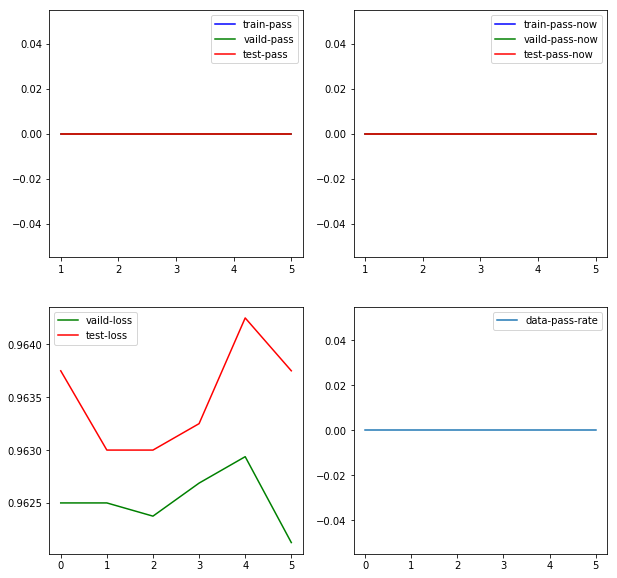

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
# plt.plot(x,train_loss_lt, label="train-loss", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

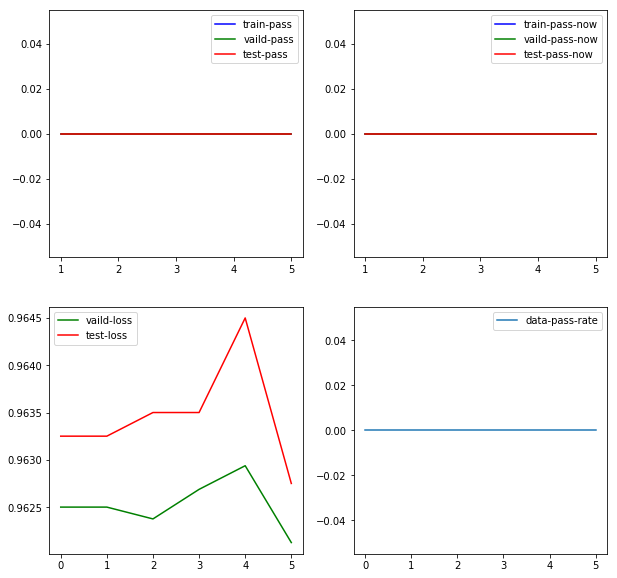

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
# plt.plot(x,train_loss_lt, label="train-loss", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

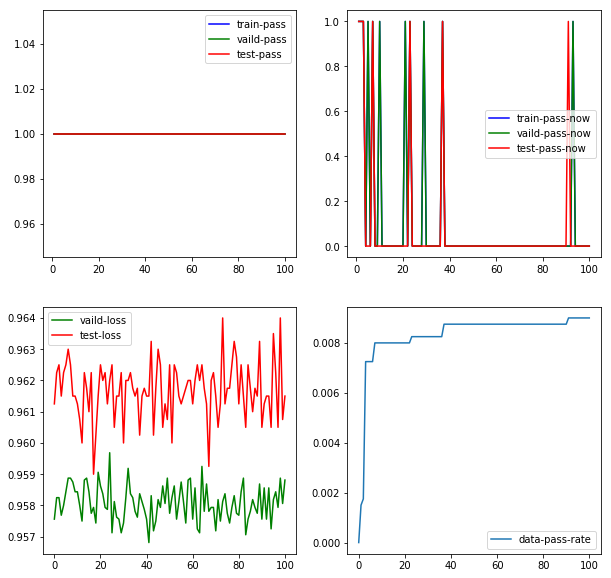

In [331]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
# plt.plot(x,train_loss_lt, label="train-loss", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

In [332]:
np.max(np.array(test_loss_lt))

0.96399999999999997

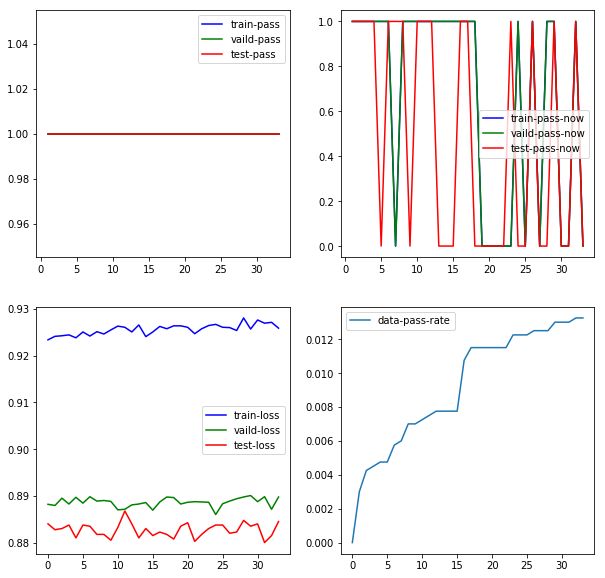

In [307]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
plt.plot(x,train_loss_lt, label="train-loss", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

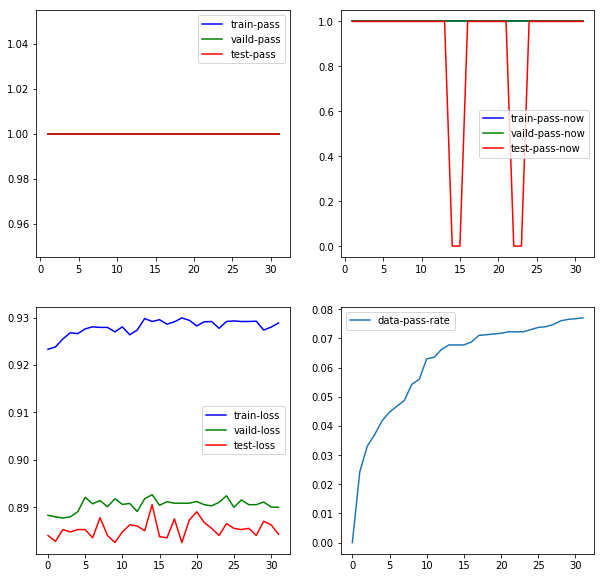

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
plt.plot(x,train_loss_lt, label="train-loss", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

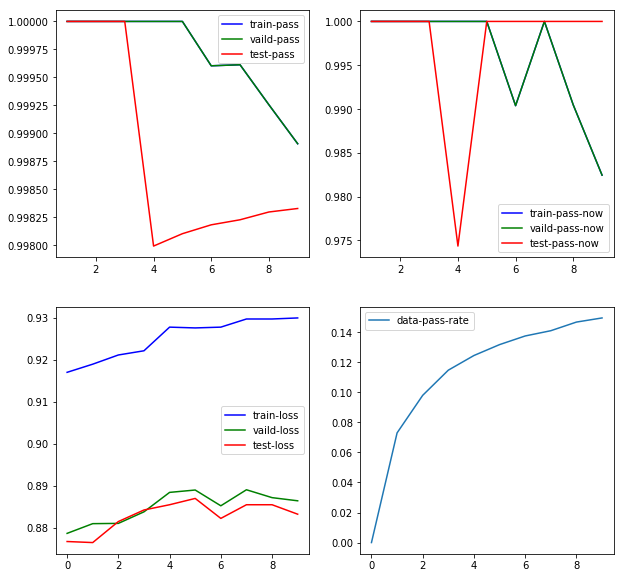

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
plt.plot(x,train_loss_lt, label="train-loss", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

In [201]:
pass_test_loss_lt_now[1:]

[0.99928977272727271,
 0.99489795918367352,
 1.0,
 1.0,
 1.0,
 0.98958333333333337,
 0.99212598425196852,
 0.99270072992700731,
 1.0,
 0.90909090909090906,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.94999999999999996,
 1.0]

In [145]:
print("data auc", metrics.roc_auc_score(y_sub, test_y))
print("data log", metrics.log_loss(y_sub, test_y))
print("data acc", acc_prob(y_sub, test_y))

data auc 0.913834654713
data log 0.306926614716
data acc 0.861494994165


# Todo list
- 树结构设计（完成）
- 通过gini对数据分割（完成）
- 全局测试集
- 输出结果集
- 打印信息增加pass data的比例
- 防止过拟合
- 对pass data的进一步处理
- 先进行数据均衡化是不是更快一些